In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [2]:
import bootstrap
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
import tensorflow as tf
import tensorflow.keras as keras
import tf_utilities as tfu
from scipy.spatial import KDTree
from scipy import stats
import wandb

from common.models import dnabert, dnagast, gast
from common.metrics import chamfer_distance_matrix, chamfer_distance_extend_matrix, mds, mds_stress_analysis
from common.data import find_dbs, DnaSampleGenerator, DnaLabelType
from common.utils import plt_to_image

## Configuration

In [97]:
metric_labels = {
    "amean": "Arithmetic Mean",
    "gmean": "Geometric Mean",
    "hmean": "Harmonic Mean"
}

In [3]:
N = 10 # Number of groups for confidence intervals
control_subsamples_per_sample = 10
test_subsamples_per_sample = 10

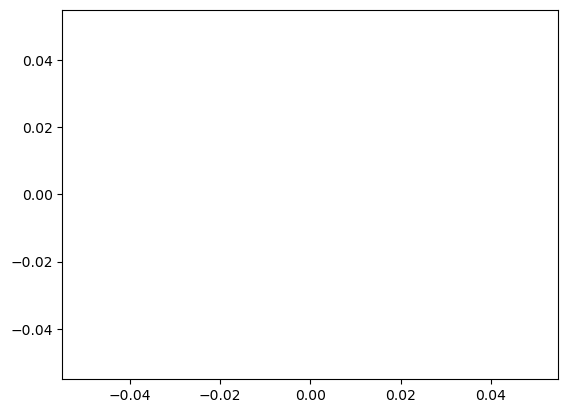

In [4]:
# Must plot before changing config otherwise plots won't display...
plt.plot([], [])

In [5]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [6]:
strategy = tfu.strategy.gpu(0)

## Connect to W&B

In [7]:
api = wandb.Api()

## Fetch DNABERT Model

Here we download the DNABERT model used with each of the DNAGAST models to embed the DNA sequences.

In [8]:
# path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-8dim:latest").download()
path = "../artifacts/dnabert-pretrain-8dim:v0/"
path

'../artifacts/dnabert-pretrain-8dim:v0/'

In [9]:
dnabert_pretrain = dnabert.DnaBertPretrainModel.load(path)
dnabert_pretrain.load_weights(path + "/model.h5") # load weights while MHA bug exists
dnabert_encoder = dnabert.DnaBertEncoderModel(dnabert_pretrain.base, use_kmer_encoder=True)

## Fetch Samples

Next, we download the DNA dataset that was used.

In [14]:
# samples_path = api.artifact("sirdavidludwig/nachusa-dna/dnasamples-complete:v0").download()
samples_path = "../artifacts/dnasamples-complete:v0/"
samples_path

'../artifacts/dnasamples-complete:v0/'

In [15]:
sample_files = find_dbs(samples_path)
len(sample_files)

210

Because of the seeded runs of DNAGAST, the following samples were selected pseudo-randomly from the complete dataset.

In [16]:
eval_samples = [
    "Wes34-8-L_S35",
    "WS-CCE-Sep2015_S60",
    "Wes33-8-TC_S34",
    "WS-MR-Sep2015_S67",
    "Wesley026-Ag-072820_S165"
]

In [17]:
samples = [f for s in eval_samples for f in sample_files if s in f]
samples

['../artifacts/dnasamples-complete:v0/train/Wes34-8-L_S35_L001_R1_001.db',
 '../artifacts/dnasamples-complete:v0/train/WS-CCE-Sep2015_S60_L001_R1_001.db',
 '../artifacts/dnasamples-complete:v0/train/Wes33-8-TC_S34_L001_R1_001.db',
 '../artifacts/dnasamples-complete:v0/train/WS-MR-Sep2015_S67_L001_R1_001.db',
 '../artifacts/dnasamples-complete:v0/train/Wesley026-Ag-072820_S165_L001_R1_001.db']

## Generate Control Samples

Now we need to generate some control subsamples from the original data, embed them using DNABERT, and compute a chamfer distance matrix.

In [18]:
subsamples = []
for i in range(N):
    subsamples.append([])
    for sample in samples:
        batch = DnaSampleGenerator([sample], sequence_length=150, subsample_length=1000, batch_size=10, batches_per_epoch=1)[0]
        subsamples[-1].append(batch)
subsamples = np.array(subsamples)
subsamples.shape

(10, 5, 10, 1000, 150)

In [19]:
subsamples_encoded = dnabert_encoder.predict(
    subsamples.reshape((-1, 150)),
    batch_size=512)
shape = (N, -1, 1000, dnabert_encoder.base.embed_dim)
control_samples = [[KDTree(s) for s in g] for g in np.reshape(subsamples_encoded, shape)]
len(control_samples)

977/977 [==============================] - 47s 47ms/step


10

In [21]:
control_dist_mats = []
for i, group in enumerate(control_samples):
    print(f"\r{i+1}/{N}", end="")
    control_dist_mats.append(chamfer_distance_matrix(group, p=1, workers=16))

10/10

## DNAGAST

Next we must download and load the various DNAGAST models we wish to evaluate.

In [22]:
prefix = "./tmp"

In [23]:
file_names = [
    "model.data",
    "model.h5",
    "model/keras_metadata.pb",
    "model/saved_model.pb",
    "model/variables/variables.data-00000-of-00001",
    "model/variables/variables.index"
]

In [24]:
run_ids = {
    "dnagast": "sirdavidludwig/dnagast/i375c4wz",
    "dnawgast": "sirdavidludwig/dnagast/19qcyd7b",
    "dnaveegast": "sirdavidludwig/dnagast/1ptvzb6q",
    "dnaveewgast": "sirdavidludwig/dnagast/2fs0re2k"
}

In [25]:
runs = {key: api.run(value) for key, value in run_ids.items()}

In [26]:
for key, run in runs.items():
    for f in run.files(names=file_names):
        path_to = os.path.join(prefix, key)
        print(os.path.join(path_to, f.name))
        f.download(path_to, replace=True)

./tmp/dnagast/model.data
./tmp/dnagast/model.h5
./tmp/dnagast/model/keras_metadata.pb
./tmp/dnagast/model/saved_model.pb
./tmp/dnagast/model/variables/variables.data-00000-of-00001
./tmp/dnagast/model/variables/variables.index
./tmp/dnawgast/model.data
./tmp/dnawgast/model.h5
./tmp/dnawgast/model/keras_metadata.pb
./tmp/dnawgast/model/saved_model.pb
./tmp/dnawgast/model/variables/variables.data-00000-of-00001
./tmp/dnawgast/model/variables/variables.index
./tmp/dnaveegast/model.data
./tmp/dnaveegast/model.h5
./tmp/dnaveegast/model/keras_metadata.pb
./tmp/dnaveegast/model/saved_model.pb
./tmp/dnaveegast/model/variables/variables.data-00000-of-00001
./tmp/dnaveegast/model/variables/variables.index
./tmp/dnaveewgast/model.data
./tmp/dnaveewgast/model.h5
./tmp/dnaveewgast/model/keras_metadata.pb
./tmp/dnaveewgast/model/saved_model.pb
./tmp/dnaveewgast/model/variables/variables.data-00000-of-00001
./tmp/dnaveewgast/model/variables/variables.index


In [27]:
models = {}
for key in runs:
    print(key)
    models[key] = dnagast.DnaSampleConditionalWGan.load(os.path.join(prefix, key, "model"))
    # try:
    #     models[key].load_weights(os.path.join(prefix, key, "model.h5"))
    # except:
    #     print("  Trying pickled weights...")
    # with open(os.path.join(prefix, key, "model.data"), "rb") as f:
    #     models[key].set_weights(pickle.load(f))

dnagast
dnawgast
dnaveegast
dnaveewgast


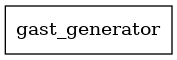

In [35]:
tf.keras.utils.plot_model(models["dnagast"].generator)

## Compute Full Distance Matrices

In [28]:
distance_matrices = {}
for key in models:
    distance_matrices[key] = []
    for i in range(N):
        print(f"\r{key}: {i+1}/{N}", end="")
        # Generate fake samples
        test_labels = np.repeat(np.arange(len(samples)), test_subsamples_per_sample)
        test_input = models[key].generator.generate_input(len(test_labels), labels=test_labels)
        fake_samples = models[key].generator.predict(test_input)
        fake_samples = [KDTree(s) for s in fake_samples]

        # Compute the distances
        distance_matrix = chamfer_distance_extend_matrix(
            control_samples[i],
            fake_samples,
            control_dist_mats[i],
            p=1,
            workers=16)
        distance_matrices[key].append(distance_matrix)

2/2 [==============================] - 0s 18ms/step


## MDS Plots

In [38]:
pcas = []
ax_min = np.inf
ax_max = -np.inf
for i, key in enumerate(models):
    pca = mds(distance_matrices[key][0])[0]
    ax_min = min(ax_min, np.min(pca))
    ax_max = max(ax_max, np.max(pca))
    pcas.append(pca)

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

legend_points = []

legend_points.append(axs[0][0].scatter([], [], color="dimgrey", marker='x'))
legend_points.append(axs[0][0].scatter([], [], color="dimgrey"))

for i, key in enumerate(models):

    ax = axs[i // 2][i % 2]

    pca = pcas[i]
    real, fake = pca[:len(control_samples[0])], pca[len(control_samples[0]):]
    cmap = plt.get_cmap("tab10")
    scale = ax_max - ax_min
    points = []
    for j, offset in enumerate(range(0, len(real), control_subsamples_per_sample)):
        data = real[offset:offset + control_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), marker='x', s=20)
        if i == 0:
            legend_points.append(points)
    for j, offset in enumerate(range(0, len(fake), test_subsamples_per_sample)):
        data = fake[offset:offset + test_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), s=10)
        if i == 0:
            legend_points.append(points)
    # ax.legend(
    #     ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
    #     loc="center left",
    #     bbox_to_anchor=(1.0, 0.5))
    # ax.set_title(f"MDS of Chamfer Distances Between DNA Samples (epoch {runs['dnawgast'].summary.epoch})")
    ax.set_title(f"{key.upper()} MDS")
    pad = 0.05*scale
    ax.set_xlim((ax_min - pad, ax_max + pad))
    ax.set_ylim((ax_min - pad, ax_max + pad))
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
# fig.suptitle("Metric Multi-dimensional Scaling (MDS) Projections of Real and Synthetic Samples")
fig.legend(
    legend_points,
    ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
    ncol=len(legend_points),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03))
fig.tight_layout()
fig.savefig("../plots/dnagast_mds.pgf", bbox_inches="tight")
fig.savefig("../plots/dnagast_mds.png", bbox_inches="tight")
fig.show()

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

legend_points = []

legend_points.append(axs[0].scatter([], [], color="dimgrey", marker='x'))
legend_points.append(axs[0].scatter([], [], color="dimgrey"))

for i, key in enumerate(models):

    ax = axs[i]

    pca = pcas[i]
    real, fake = pca[:len(control_samples[0])], pca[len(control_samples[0]):]
    cmap = plt.get_cmap("tab10")
    scale = ax_max - ax_min
    points = []
    for j, offset in enumerate(range(0, len(real), control_subsamples_per_sample)):
        data = real[offset:offset + control_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), marker='x', s=20)
        if i == 0:
            legend_points.append(points)
    for j, offset in enumerate(range(0, len(fake), test_subsamples_per_sample)):
        data = fake[offset:offset + test_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), s=8)
        if i == 0:
            legend_points.append(points)
    # ax.legend(
    #     ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
    #     loc="center left",
    #     bbox_to_anchor=(1.0, 0.5))
    # ax.set_title(f"MDS of Chamfer Distances Between DNA Samples (epoch {runs['dnawgast'].summary.epoch})")
    ax.set_title(f"{key.upper()}")
    pad = 0.05*scale
    ax.set_xlim((ax_min - pad, ax_max + pad))
    ax.set_ylim((ax_min - pad, ax_max + pad))
    ax.set_xlabel("PC1")
    # if i == 0:
    ax.set_ylabel("PC2")
# fig.suptitle("Metric Multi-dimensional Scaling (MDS) Projections of Real and Synthetic Samples")
fig.legend(
    legend_points,
    ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
    ncol=len(legend_points),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.065))
fig.tight_layout()
fig.savefig("../plots/dnagast_mds.pgf", bbox_inches="tight")
fig.savefig("../plots/dnagast_mds.png", bbox_inches="tight")
fig.show()

In [41]:
from sklearn.manifold import MDS
def mds_stress_analysis(distance_matrix, dims):
    stresses = []
    for d in range(1, dims + 1):
        mds = MDS(n_components=d, dissimilarity="precomputed")
        mds.fit(distance_matrix)
        stresses.append(mds.stress_)
    return np.array(stresses) / np.sum(stresses)

In [42]:
stresses = {}
extended_distance_matrices = {}

for key in models:
    stress_list = []
    for i in range(N):
        print(f"\r{key}: {i+1}/{N}", end="")
        stress_list.append(mds_stress_analysis(distance_matrices[key][i], dims=dnabert_encoder.base.embed_dim))
    stresses[key] = np.array(stress_list)

dnaveewgast: 10/10

In [43]:
plt.figure(figsize=(6, 3.5))
for key, values in stresses.items():
    values = values[:, 1:]
    x = np.arange(values.shape[-1]) + 2
    mean = np.mean(values, axis=0)
    std = np.std(values, axis=0)

    ci = 1.96 * std/np.sqrt(N)

    plt.plot(x, mean, label=key.upper())
    plt.fill_between(x, mean - ci, mean + ci, alpha=0.25)
# plt.title("MDS Stress Scree Plot")
plt.legend()
plt.xlabel("Number of Components/Dimensions")
plt.ylabel("Percent of Total Stress")
plt.savefig("../plots/dnagast_mds_scree.pgf")
plt.savefig("../plots/dnagast_mds_scree.png")
plt.show()

In [61]:
def partition_distance_matrix(distance_matrix):
    """
    Break apart the merged distance matrix into distance matrices separated by sample
    """
    n = control_subsamples_per_sample
    m = test_subsamples_per_sample
    N = n*len(samples)
    dist_mats = np.empty((len(samples), n+m, n+m))
    for i in range(0, len(samples)):
        # Pull out matrix quadrants for common sample distances
        # A/C = real, B/D = fake
        A = distance_matrix[i*n:(i+1)*n,     i*n:(i+1)*n]     # top-left
        B = distance_matrix[i*n:(i+1)*n,     N+i*m:N+(i+1)*m] # top-right
        C = distance_matrix[N+i*m:N+(i+1)*m, i*n:(i+1)*n]     # bottom-left
        D = distance_matrix[N+i*m:N+(i+1)*m, N+i*m:N+(i+1)*m] # bottom-right

        # Merge into a single distance matrix
        AB = np.concatenate((A, B), axis=1)
        CD = np.concatenate((C, D), axis=1)
        dist_mats[i] = np.concatenate((AB, CD), axis=0)
    return dist_mats

def compute_compactness(distance_matrices):
    n = control_subsamples_per_sample
    fns = {"amean": np.mean, "gmean": stats.gmean, "hmean": stats.hmean}
    results = [{l: [] for l in fns} for i in range(len(samples))]
    for distance_matrix in distance_matrices:
        dist_mats = partition_distance_matrix(distance_matrix)
        for i in range(len(samples)):
            d = dist_mats[i]

            real_to_real_subsamples = d[:n,:n][np.triu_indices(n, 1)]
            fake_to_fake_subsamples = d[n:,n:][np.triu_indices(len(dist_mats[0]) - n, 1)]

            for key, fn in fns.items():
                real = fn(real_to_real_subsamples)
                fake = fn(fake_to_fake_subsamples)
                results[i][key].append(real / fake)
    return results

def compute_compactness_merged(distance_matrices):
    n = control_subsamples_per_sample
    fns = {"amean": np.mean, "gmean": stats.gmean, "hmean": stats.hmean}
    results = {l: [] for l in fns}
    for distance_matrix in distance_matrices:
        dist_mats = partition_distance_matrix(distance_matrix)
        for i in range(len(samples)):
            d = dist_mats[i]

            real_to_real_subsamples = d[:n,:n][np.triu_indices(n, 1)]
            fake_to_fake_subsamples = d[n:,n:][np.triu_indices(len(dist_mats[0]) - n, 1)]

            for key, fn in fns.items():
                real = fn(real_to_real_subsamples)
                fake = fn(fake_to_fake_subsamples)
                results[key].append(real / fake)
    return results

def compute_spread(distance_matrices):
    n = control_subsamples_per_sample*len(samples)
    fns = {"amean": np.mean, "gmean": stats.gmean, "hmean": stats.hmean}
    results = {l: [] for l in fns}

    for distance_matrix in distance_matrices:
        real_to_real_subsamples = distance_matrix[:n,:n][np.triu_indices(n, 1)]
        fake_to_fake_subsamples = distance_matrix[n:,n:][np.triu_indices(len(distance_matrix) - n, 1)]

        for key, fn in fns.items():
            real = fn(real_to_real_subsamples)
            fake = fn(fake_to_fake_subsamples)
            results[key].append(real / fake)
    return results

## Real to Fake Distances

In [148]:
real_fake_distances = {}
for model in models:
    real_fake_distances[model] = [{"amean": [], "gmean": [], "hmean": []} for _ in samples]
    for i in range(N):
        d = partition_distance_matrix(distance_matrices[model][i])
        for j in range(len(samples)):
            distances = d[j][:control_subsamples_per_sample,control_subsamples_per_sample:].flatten()
            real_fake_distances[model][j]["amean"].append(np.mean(distances))
            real_fake_distances[model][j]["gmean"].append(stats.gmean(distances))
            real_fake_distances[model][j]["hmean"].append(stats.hmean(distances))

In [118]:
distances.shape

(100,)

In [122]:
distance_matrices["dnagast"][0].shape

(100, 100)

In [115]:
len(real_fake_distances["dnagast"])

5

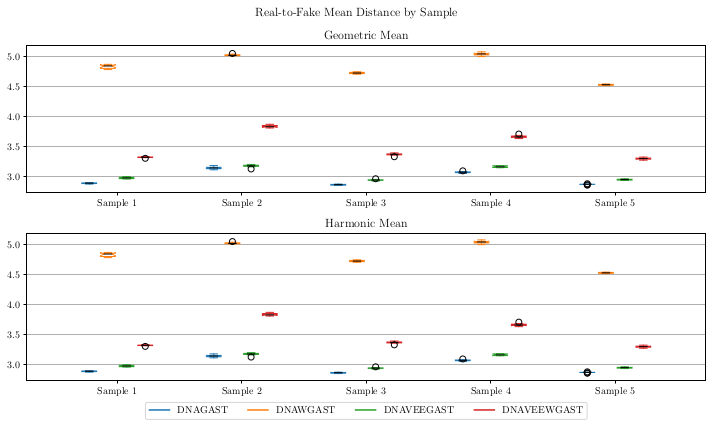

In [100]:
x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(10, 6))
# plt.suptitle("Real-to-Fake Mean Distance by Sample")
plt.subplot(211)
for i, model in enumerate(models):
    data = [real_fake_distances[model][j]["gmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
plt.title("Geometric Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

plt.subplot(212)
for i, model in enumerate(models):
    data = [real_fake_distances[model][j]["hmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))

plt.title("Harmonic Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig("../plots/dnagast_real_to_fake.pgf", bbox_inches="tight")
plt.show()

In [58]:
x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(10, 3))
# plt.suptitle("Real-to-Fake Mean Distance by Sample")
for i, model in enumerate(models):
    data = [real_fake_distances[model][j]["amean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig("../plots/dnagast_real_to_fake.pgf", bbox_inches="tight")
plt.savefig("../plots/dnagast_real_to_fake.png", bbox_inches="tight")
plt.show()

In [100]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in real_fake_distances[model]:
        row.append(np.median(sample["amean"]))
    rows.append(row)
real_fake_distances_amean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
real_fake_distances_amean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.881,3.142,2.861,3.062,2.864
1,DNAWGAST,4.832,5.039,4.722,5.049,4.534
2,DNAVEEGAST,2.967,3.179,2.937,3.152,2.943
3,DNAVEEWGAST,3.323,3.849,3.351,3.677,3.293


In [101]:
with open("../tables/dnagast_real_fake_distances_amean.tex", 'w') as f:
    f.write(real_fake_distances_amean_table.to_latex(index=False))

/tmp/ipykernel_7726/4235898658.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(real_fake_distances_amean_table.to_latex(index=False))


In [80]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in real_fake_distances[model]:
        row.append(np.median(sample["gmean"]))
    rows.append(row)
real_fake_distances_gmean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
real_fake_distances_gmean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.881,3.140,2.861,3.062,2.864
1,DNAWGAST,4.831,5.038,4.722,5.048,4.534
2,DNAVEEGAST,2.967,3.177,2.937,3.151,2.943
3,DNAVEEWGAST,3.322,3.849,3.351,3.676,3.293


In [81]:
with open("../tables/dnagast_real_fake_distances_gmean.tex", 'w') as f:
    f.write(real_fake_distances_gmean_table.to_latex(index=False))

/tmp/ipykernel_7726/1479822035.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(real_fake_distances_gmean_table.to_latex(index=False))


In [82]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in real_fake_distances[model]:
        row.append(np.median(sample["hmean"]))
    rows.append(row)
real_fake_distances_hmean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
real_fake_distances_hmean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.881,3.138,2.861,3.061,2.863
1,DNAWGAST,4.831,5.038,4.722,5.048,4.534
2,DNAVEEGAST,2.966,3.176,2.937,3.151,2.943
3,DNAVEEWGAST,3.322,3.848,3.350,3.675,3.292


In [83]:
with open("../tables/dnagast_real_fake_distance_hmean.tex", 'w') as f:
    f.write(real_fake_distances_hmean_table.to_latex(index=False))

/tmp/ipykernel_7726/438744111.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(real_fake_distances_hmean_table.to_latex(index=False))


## Real to Fake Distances Merged

In [155]:
# real_fake_distances_merged = {}
# for model in models:
#     real_fake_distances_merged[model] = [{"amean": [], "gmean": [], "hmean": []} for _ in samples]
#     for i in range(N):
#         d = partition_distance_matrix(distance_matrices[model][i])
#         for j in range(len(samples)):
#             distances = d[j][:control_subsamples_per_sample,control_subsamples_per_sample:].flatten()
#             real_fake_distances[model][j]["amean"].append(np.mean(distances))
#             real_fake_distances[model][j]["gmean"].append(stats.gmean(distances))
#             real_fake_distances[model][j]["hmean"].append(stats.hmean(distances))

In [182]:
real_fake_distances_merged = {}
for model in models:
    real_fake_distances_merged[model] = {"amean": [], "gmean": [], "hmean": []}
    for i in range(N):
        d = partition_distance_matrix(distance_matrices[model][i])
        d = d[:,:control_subsamples_per_sample,control_subsamples_per_sample:].flatten()
        real_fake_distances_merged[model]["amean"].append(np.mean(d))
        real_fake_distances_merged[model]["gmean"].append(stats.gmean(d))
        real_fake_distances_merged[model]["hmean"].append(stats.hmean(d))

In [183]:
x = np.arange(3) # metric
group_width = 0.6
pad = 0.15
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(4, 3))
for i, model in enumerate(models):
    data = [real_fake_distances_merged[model][metric] for metric in ["amean", "gmean", "hmean"]]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
print()
plt.xticks(x, map(lambda x: x, ["Arithmetic Mean", "Geometric Mean", "Harmonic Mean"]))
plt.grid(axis='y')
plt.xlim((x[0] - group_width/2 - pad, x[-1] + group_width/2 + pad))

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

# plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.14))
plt.legend(loc="lower center", ncol=len(models)//2, bbox_to_anchor=(0.5, -0.35), prop={"size": 8})
# plt.legend(prop={"size": 8})
plt.tight_layout()
plt.savefig("../plots/dnagast_distance.pgf", bbox_inches="tight")
plt.savefig("../plots/dnagast_distance.png", bbox_inches="tight")
plt.show()

In [184]:
rows = []
for model in real_fake_distances_merged:
    row = {"Model": model.upper()}
    for metric in real_fake_distances_merged[model]:
        label = metric_labels[metric]
        row[label] = np.median(real_fake_distances_merged[model][metric])
    rows.append(row)
real_fake_distances_merged_table = pd.DataFrame(rows).round(3)
real_fake_distances_merged_table

,Model,Arithmetic Mean,Geometric Mean,Harmonic Mean
0,DNAGAST,2.964,2.961,2.959
1,DNAWGAST,4.836,4.832,4.828
2,DNAVEEGAST,3.040,3.037,3.035
3,DNAVEEWGAST,3.494,3.487,3.481


In [185]:
with open("../tables/dnagast_real_fake_distances.tex", 'w') as f:
    f.write(real_fake_distances_merged_table.to_latex(index=False))

/tmp/ipykernel_2675/1160953876.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(real_fake_distances_merged_table.to_latex(index=False))


## Intra-cluster Distances

In [87]:
compactness = {m: compute_compactness(distance_matrices[m]) for m in models}

In [58]:
len(compactness["dnagast"])

5

In [70]:
spread = {m: compute_spread(distance_matrices[m]) for m in models}

In [52]:
x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(10, 6))
plt.suptitle("Real/Fake Intra-cluster Mean Distance Ratios by Sample")
plt.subplot(211)
for i, model in enumerate(models):
    data = [compactness[model][j]["gmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
plt.title("Geometric Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

plt.subplot(212)
for i, model in enumerate(models):
    data = [compactness[model][j]["hmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))

plt.title("Harmonic Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig("../plots/dnagast_intra_distance.pgf", bbox_inches="tight")
plt.show()

In [57]:
x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(10, 3))
for i, model in enumerate(models):
    data = [compactness[model][j]["amean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig("../plots/dnagast_intra_distance.pgf", bbox_inches="tight")
plt.savefig("../plots/dnagast_intra_distance.png", bbox_inches="tight")
plt.show()

In [67]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in compactness[model]:
        row.append(np.median(sample["amean"]))
    rows.append(row)
compactness_amean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
compactness_amean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.071,1.554,1.865,1.706,1.881
1,DNAWGAST,1.253,1.219,1.291,1.188,1.281
2,DNAVEEGAST,1.562,1.260,1.554,1.374,1.602
3,DNAVEEWGAST,2.349,1.798,2.430,1.771,2.272


In [73]:
with open("../tables/dnagast_intra_distance_amean.tex", 'w') as f:
    f.write(compactness_amean_table.to_latex(index=False))

/tmp/ipykernel_7726/3369589827.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(compactness_amean_table.to_latex(index=False))


In [69]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in compactness[model]:
        row.append(np.median(sample["gmean"]))
    rows.append(row)
compactness_gmean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
compactness_gmean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.119,1.605,1.911,1.742,1.952
1,DNAWGAST,1.282,1.235,1.317,1.211,1.312
2,DNAVEEGAST,1.576,1.284,1.570,1.388,1.621
3,DNAVEEWGAST,2.374,1.823,2.448,1.792,2.313


In [74]:
with open("../tables/dnagast_intra_distance_gmean.tex", 'w') as f:
    f.write(compactness_gmean_table.to_latex(index=False))

/tmp/ipykernel_7726/1294339864.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(compactness_gmean_table.to_latex(index=False))


In [75]:
rows = []
for model in spread:
    row = [model.upper()]
    for sample in compactness[model]:
        row.append(np.median(sample["hmean"]))
    rows.append(row)
compactness_hmean_table = pd.DataFrame(rows, columns=["Model", *[f"Sample {i+1}" for i in range(len(samples))]]).round(3)
compactness_hmean_table

,Model,Sample 1,Sample 2,Sample 3,Sample 4,Sample 5
0,DNAGAST,2.154,1.673,1.966,1.781,2.003
1,DNAWGAST,1.317,1.251,1.347,1.234,1.344
2,DNAVEEGAST,1.596,1.310,1.587,1.403,1.638
3,DNAVEEWGAST,2.398,1.852,2.467,1.817,2.352


In [76]:
with open("../tables/dnagast_intra_distance_hmean.tex", 'w') as f:
    f.write(compactness_hmean_table.to_latex(index=False))

/tmp/ipykernel_7726/3352310552.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(compactness_hmean_table.to_latex(index=False))


## Merged Intra-cluster Distances

In [64]:
compactness_merged = {m: compute_compactness_merged(distance_matrices[m]) for m in models}

In [67]:
len(compactness_merged["dnagast"]["amean"])

50

In [93]:
x = np.arange(3) # metric
group_width = 0.6
pad = 0.15
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(4, 3))
for i, model in enumerate(models):
    data = [compactness_merged[model][metric] for metric in ["amean", "gmean", "hmean"]]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
print()
plt.xticks(x, map(lambda x: x, ["Arithmetic Mean", "Geometric Mean", "Harmonic Mean"]))
plt.grid(axis='y')
plt.xlim((x[0] - group_width/2 - pad, x[-1] + group_width/2 + pad))

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models)//2, bbox_to_anchor=(0.5, -0.35), prop={"size": 8})
# plt.legend(prop={"size": 8})
plt.tight_layout()
plt.savefig("../plots/dnagast_intra_distance.pgf", bbox_inches="tight")
plt.savefig("../plots/dnagast_intra_distance.png", bbox_inches="tight")
plt.show()

In [108]:
rows = []
for model in compactness_merged:
    row = {"Model": model.upper()}
    for metric in compactness_merged[model]:
        label = metric_labels[metric]
        row[label] = np.median(compactness_merged[model][metric])
    rows.append(row)
compactness_merged_table = pd.DataFrame(rows).round(3)
compactness_merged_table

,Model,Arithmetic Mean,Geometric Mean,Harmonic Mean
0,DNAGAST,1.865,1.909,1.963
1,DNAWGAST,1.263,1.284,1.306
2,DNAVEEGAST,1.516,1.535,1.551
3,DNAVEEWGAST,2.285,2.314,2.340


In [109]:
with open("../tables/dnagast_intra_distance.tex", 'w') as f:
    f.write(compactness_merged_table.to_latex(index=False))

/tmp/ipykernel_2675/189571432.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(compactness_merged_table.to_latex(index=False))


## Inter-cluster Distances

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.autofmt_xdate(rotation=0)

ax1.boxplot([spread[m]["amean"] for m in models], notch=True, vert=True, labels=[m.upper() for m in models], widths=0.25)
ax1.set_title("Arithmetic Mean")
ax1.grid(axis='y')
# ax1.set_xticklabels(rotation=90)

ax2.boxplot([spread[m]["gmean"] for m in models], notch=True, vert=True, labels=[m.upper() for m in models], widths=0.25)
ax2.set_title("Geometric Mean")
ax2.grid(axis='y')
# plt.xticks(rotation=45)

ax3.boxplot([spread[m]["hmean"] for m in models], notch=True, vert=True, labels=[m.upper() for m in models], widths=0.25)
ax3.set_title("Harmonic Mean")
ax3.grid(axis='y')
# plt.xticks(rotation=45)

fig.suptitle("Real/Fake Inter-cluster Mean Distance Ratios")
fig.tight_layout()
fig.savefig("../plots/dnagast_inter_distance.pgf")
fig.savefig("../plots/dnagast_inter_distance.png")
fig.show()

In [111]:
x = np.arange(3) # metric
group_width = 0.6
pad = 0.15
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(4, 3))
for i, model in enumerate(models):
    data = [spread[model][metric] for metric in ["amean", "gmean", "hmean"]]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
print()
plt.xticks(x, map(lambda x: x, ["Arithmetic Mean", "Geometric Mean", "Harmonic Mean"]))
plt.grid(axis='y')
plt.xlim((x[0] - group_width/2 - pad, x[-1] + group_width/2 + pad))

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

# plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.14))
plt.legend(loc="lower center", ncol=len(models)//2, bbox_to_anchor=(0.5, -0.35), prop={"size": 8})
# plt.legend(prop={"size": 8})
plt.tight_layout()
plt.savefig("../plots/dnagast_inter_distance.pgf", bbox_inches="tight")
plt.savefig("../plots/dnagast_inter_distance.png", bbox_inches="tight")
plt.show()

In [112]:
rows = []
for model in spread:
    amean = np.median(spread[model]["amean"])
    gmean = np.median(spread[model]["gmean"])
    hmean = np.median(spread[model]["hmean"])
    rows.append([model.upper(), amean, gmean, hmean])
spread_table = pd.DataFrame(rows, columns=["Model", "Arithmetic Mean", "Geometric Mean", "Harmonic Mean"]).round(3)
spread_table

,Model,Arithmetic Mean,Geometric Mean,Harmonic Mean
0,DNAGAST,1.084,1.158,1.318
1,DNAWGAST,1.085,1.028,1.013
2,DNAVEEGAST,1.040,1.097,1.198
3,DNAVEEWGAST,1.028,1.223,1.560


In [113]:
with open("../tables/dnagast_inter_distance.tex", 'w') as f:
    f.write(spread_table.to_latex(index=False))

/tmp/ipykernel_2675/1342623163.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(spread_table.to_latex(index=False))
